In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

%matplotlib inline
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('../datasets/yummly/recipes_from_api_new.csv')
df.drop('id', axis=1, inplace=True)
df.set_index('link', inplace=True)
df.head()

,name,totalTime,rating,category,cuisine,tags,IngredientsWithAmount,Ingredients,NutritionValues
link,,,,,,,,,
https://www.yummly.com/recipe/The-Best-Asian-Vegetables-2574596,The Best Asian Vegetables,35 min,4.0,NaN,Asian,"[{'cuisine': ['Asian']}, {'difficulty': ['Easy...","['two Tablespoons vegetable oil', '2 medium zu...","['vegetable oil', 'medium zucchini', 'broccoli...","{'FAT_KCAL': '90.0kcal', 'K': '0.57g', 'FASAT'..."
https://www.yummly.com/recipe/Best-Asian-Meatball-1110225,Best Asian Meatball,1 hr,4.0,Main Dishes,Chinese,"[{'course': ['Main Dishes']}, {'cuisine': ['Ch...","['1lb lean ground beef', '½ cup white onion (m...","['lean ground beef', 'white onion', 'egg', 'ga...","{'FAT_KCAL': '70.0kcal', 'K': '0.69g', 'FASAT'..."
https://www.yummly.com/recipe/The-Best-Asian-Peanut-Sauce-9374100,The Best Asian Peanut Sauce,10 min,4.0,Condiments and Sauces,Asian,"[{'course': ['Condiments and Sauces']}, {'cuis...","['2 tablespoons light coconut milk', '1/4 cup ...","['light coconut milk', 'low sodium chicken bro...","{'FAT_KCAL': '120.0kcal', 'K': '0.23g', 'FASAT..."
https://www.yummly.com/recipe/Best-Asian-Garlic-Paleo-Whole30-Noodles-2385453,Best Asian Garlic Paleo Whole30 Noodles,10 min,4.0,NaN,Asian,"[{'cuisine': ['Asian']}, {'difficulty': ['Quic...",['1 large cooked spaghetti squash see notes on...,"['spaghetti squash', 'medium zucchini', 'large...","{'FAT_KCAL': '100.0kcal', 'K': '0.75g', 'FASAT..."
https://www.yummly.com/recipe/The-Best-Asian-Style-Green-Beans-9599331,The Best Asian Style Green Beans,15 min,4.0,Side Dishes,NaN,"[{'course': ['Side Dishes']}, {'difficulty': [...",['2 lbs frozen or fresh whole green beans (If ...,"['green beans', 'olive oil', 'soy sauce', 'gra...","{'FAT_KCAL': '25.0kcal', 'K': '0.24g', 'FASAT'..."


In [3]:
df.shape

(346252, 9)

In [4]:
df.drop_duplicates(inplace=True)
df.shape

(164982, 9)

In [5]:
df.reset_index(drop=True, inplace=True)
df

,name,totalTime,rating,category,cuisine,tags,IngredientsWithAmount,Ingredients,NutritionValues
0,The Best Asian Vegetables,35 min,4.0,NaN,Asian,"[{'cuisine': ['Asian']}, {'difficulty': ['Easy...","['two Tablespoons vegetable oil', '2 medium zu...","['vegetable oil', 'medium zucchini', 'broccoli...","{'FAT_KCAL': '90.0kcal', 'K': '0.57g', 'FASAT'..."
1,Best Asian Meatball,1 hr,4.0,Main Dishes,Chinese,"[{'course': ['Main Dishes']}, {'cuisine': ['Ch...","['1lb lean ground beef', '½ cup white onion (m...","['lean ground beef', 'white onion', 'egg', 'ga...","{'FAT_KCAL': '70.0kcal', 'K': '0.69g', 'FASAT'..."
2,The Best Asian Peanut Sauce,10 min,4.0,Condiments and Sauces,Asian,"[{'course': ['Condiments and Sauces']}, {'cuis...","['2 tablespoons light coconut milk', '1/4 cup ...","['light coconut milk', 'low sodium chicken bro...","{'FAT_KCAL': '120.0kcal', 'K': '0.23g', 'FASAT..."
3,Best Asian Garlic Paleo Whole30 Noodles,10 min,4.0,NaN,Asian,"[{'cuisine': ['Asian']}, {'difficulty': ['Quic...",['1 large cooked spaghetti squash see notes on...,"['spaghetti squash', 'medium zucchini', 'large...","{'FAT_KCAL': '100.0kcal', 'K': '0.75g', 'FASAT..."
4,The Best Asian Style Green Beans,15 min,4.0,Side Dishes,NaN,"[{'course': ['Side Dishes']}, {'difficulty': [...",['2 lbs frozen or fresh whole green beans (If ...,"['green beans', 'olive oil', 'soy sauce', 'gra...","{'FAT_KCAL': '25.0kcal', 'K': '0.24g', 'FASAT'..."
...,...,...,...,...,...,...,...,...,...
164977,Turkish Gozleme,50 min,4.0,NaN,NaN,[],['3 cup all purpose flour (more to use when ro...,"['all purpose flour', 'salt', 'instant yeast',...","{'FAT_KCAL': '110.0kcal', 'K': '0.34g', 'FASAT..."
164978,Turkish Eggs,25 min,4.0,Breakfast and Brunch,NaN,"[{'course': ['Breakfast and Brunch']}, {'nutri...","['1 cup Greek yogurt', '2 garlic cloves grated...","['Greek yogurt', 'garlic cloves', 'salt', 'bla...","{'FAT_KCAL': '170.0kcal', 'K': '0.21g', 'FASAT..."
164979,Turkish Tomatoes,1 hr,4.2,Side Dishes,NaN,"[{'course': ['Side Dishes']}, {'difficulty': [...","['8 -10 large tomatoes', '60 ml olive oil', '2...","['tomatoes', 'olive oil', 'onion', 'eggplant',...","{'FAT_KCAL': '170.0kcal', 'K': '1.21g', 'FASAT..."
164980,Swedish Heirloom Cookies with Walnuts,24 min,4.0,Desserts,Swedish,"[{'course': ['Desserts']}, {'cuisine': ['Swedi...","['2 cups white flour', '2 sticks softened butt...","['white flour', 'softened butter', 'salt', 'su...","{'FAT_KCAL': '700.0kcal', 'K': '0.31g', 'FASAT..."


In [6]:
df.cuisine.value_counts()

Asian                   6610
Italian                 4852
Mexican                 4642
Indian                  3706
Thai                    3649
Greek                   3620
Korean                  3245
Chinese                 2516
Japanese                2461
Vietnamese              2174
French                  1954
Mediterranean           1905
Southern & Soul Food    1817
Spanish                 1634
Moroccan                1406
Irish                   1389
Barbecue                1374
German                  1094
Filipino                1059
Cuban                    969
Jamaican                 931
Brazilian                908
American                 666
Cajun & Creole           613
Hungarian                498
Hawaiian                 415
Kid-Friendly             406
Southwestern             351
Portuguese               206
Swedish                  153
Ethiopian                123
English                  123
Turkish                   89
Russian                   76
Jewish        

In [7]:
value_counts = df['cuisine'].value_counts()
to_remove = value_counts[value_counts <= 900].index
df = df[~df.cuisine.isin(to_remove)]

df.reset_index(drop=True, inplace=True)
df

,name,totalTime,rating,category,cuisine,tags,IngredientsWithAmount,Ingredients,NutritionValues
0,The Best Asian Vegetables,35 min,4.0,NaN,Asian,"[{'cuisine': ['Asian']}, {'difficulty': ['Easy...","['two Tablespoons vegetable oil', '2 medium zu...","['vegetable oil', 'medium zucchini', 'broccoli...","{'FAT_KCAL': '90.0kcal', 'K': '0.57g', 'FASAT'..."
1,Best Asian Meatball,1 hr,4.0,Main Dishes,Chinese,"[{'course': ['Main Dishes']}, {'cuisine': ['Ch...","['1lb lean ground beef', '½ cup white onion (m...","['lean ground beef', 'white onion', 'egg', 'ga...","{'FAT_KCAL': '70.0kcal', 'K': '0.69g', 'FASAT'..."
2,The Best Asian Peanut Sauce,10 min,4.0,Condiments and Sauces,Asian,"[{'course': ['Condiments and Sauces']}, {'cuis...","['2 tablespoons light coconut milk', '1/4 cup ...","['light coconut milk', 'low sodium chicken bro...","{'FAT_KCAL': '120.0kcal', 'K': '0.23g', 'FASAT..."
3,Best Asian Garlic Paleo Whole30 Noodles,10 min,4.0,NaN,Asian,"[{'cuisine': ['Asian']}, {'difficulty': ['Quic...",['1 large cooked spaghetti squash see notes on...,"['spaghetti squash', 'medium zucchini', 'large...","{'FAT_KCAL': '100.0kcal', 'K': '0.75g', 'FASAT..."
4,The Best Asian Style Green Beans,15 min,4.0,Side Dishes,NaN,"[{'course': ['Side Dishes']}, {'difficulty': [...",['2 lbs frozen or fresh whole green beans (If ...,"['green beans', 'olive oil', 'soy sauce', 'gra...","{'FAT_KCAL': '25.0kcal', 'K': '0.24g', 'FASAT'..."
...,...,...,...,...,...,...,...,...,...
161235,Turkish Pilaf,40 min,3.2,Side Dishes,NaN,"[{'course': ['Side Dishes']}, {'difficulty': [...","['1/4 cup butter', '1 cup diced green bell pep...","['butter', 'green bell pepper', 'sliced mushro...","{'FAT_KCAL': '90.0kcal', 'K': '0.21g', 'FASAT'..."
161236,Turkish Gozleme,50 min,4.0,NaN,NaN,[],['3 cup all purpose flour (more to use when ro...,"['all purpose flour', 'salt', 'instant yeast',...","{'FAT_KCAL': '110.0kcal', 'K': '0.34g', 'FASAT..."
161237,Turkish Eggs,25 min,4.0,Breakfast and Brunch,NaN,"[{'course': ['Breakfast and Brunch']}, {'nutri...","['1 cup Greek yogurt', '2 garlic cloves grated...","['Greek yogurt', 'garlic cloves', 'salt', 'bla...","{'FAT_KCAL': '170.0kcal', 'K': '0.21g', 'FASAT..."
161238,Turkish Tomatoes,1 hr,4.2,Side Dishes,NaN,"[{'course': ['Side Dishes']}, {'difficulty': [...","['8 -10 large tomatoes', '60 ml olive oil', '2...","['tomatoes', 'olive oil', 'onion', 'eggplant',...","{'FAT_KCAL': '170.0kcal', 'K': '1.21g', 'FASAT..."


In [8]:
df.drop(columns=['name','totalTime','category','IngredientsWithAmount','NutritionValues'], axis=1, inplace=True)
df.cuisine.value_counts()

Asian                   6610
Italian                 4852
Mexican                 4642
Indian                  3706
Thai                    3649
Greek                   3620
Korean                  3245
Chinese                 2516
Japanese                2461
Vietnamese              2174
French                  1954
Mediterranean           1905
Southern & Soul Food    1817
Spanish                 1634
Moroccan                1406
Irish                   1389
Barbecue                1374
German                  1094
Filipino                1059
Cuban                    969
Jamaican                 931
Brazilian                908
Name: cuisine, dtype: int64

In [9]:
df = df[~df.cuisine.isin(['Asian', 'Barbecue'])]
df.dropna(subset=['cuisine', 'Ingredients'], inplace=True, axis=0)
df.reset_index(inplace=True, drop=True)

<AxesSubplot: >

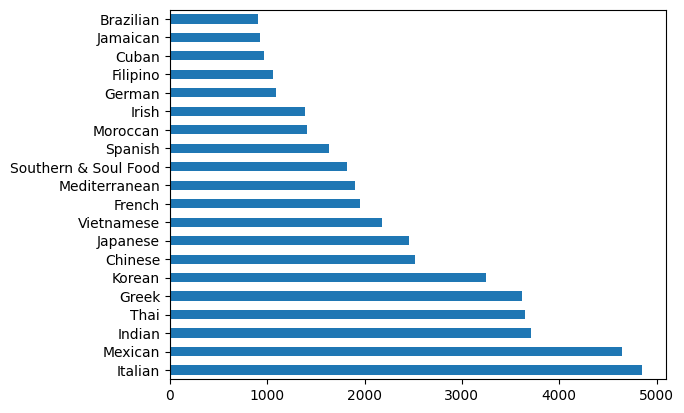

In [10]:
cuisine_names = df.cuisine.value_counts()
cuisine_names.plot(kind='barh')

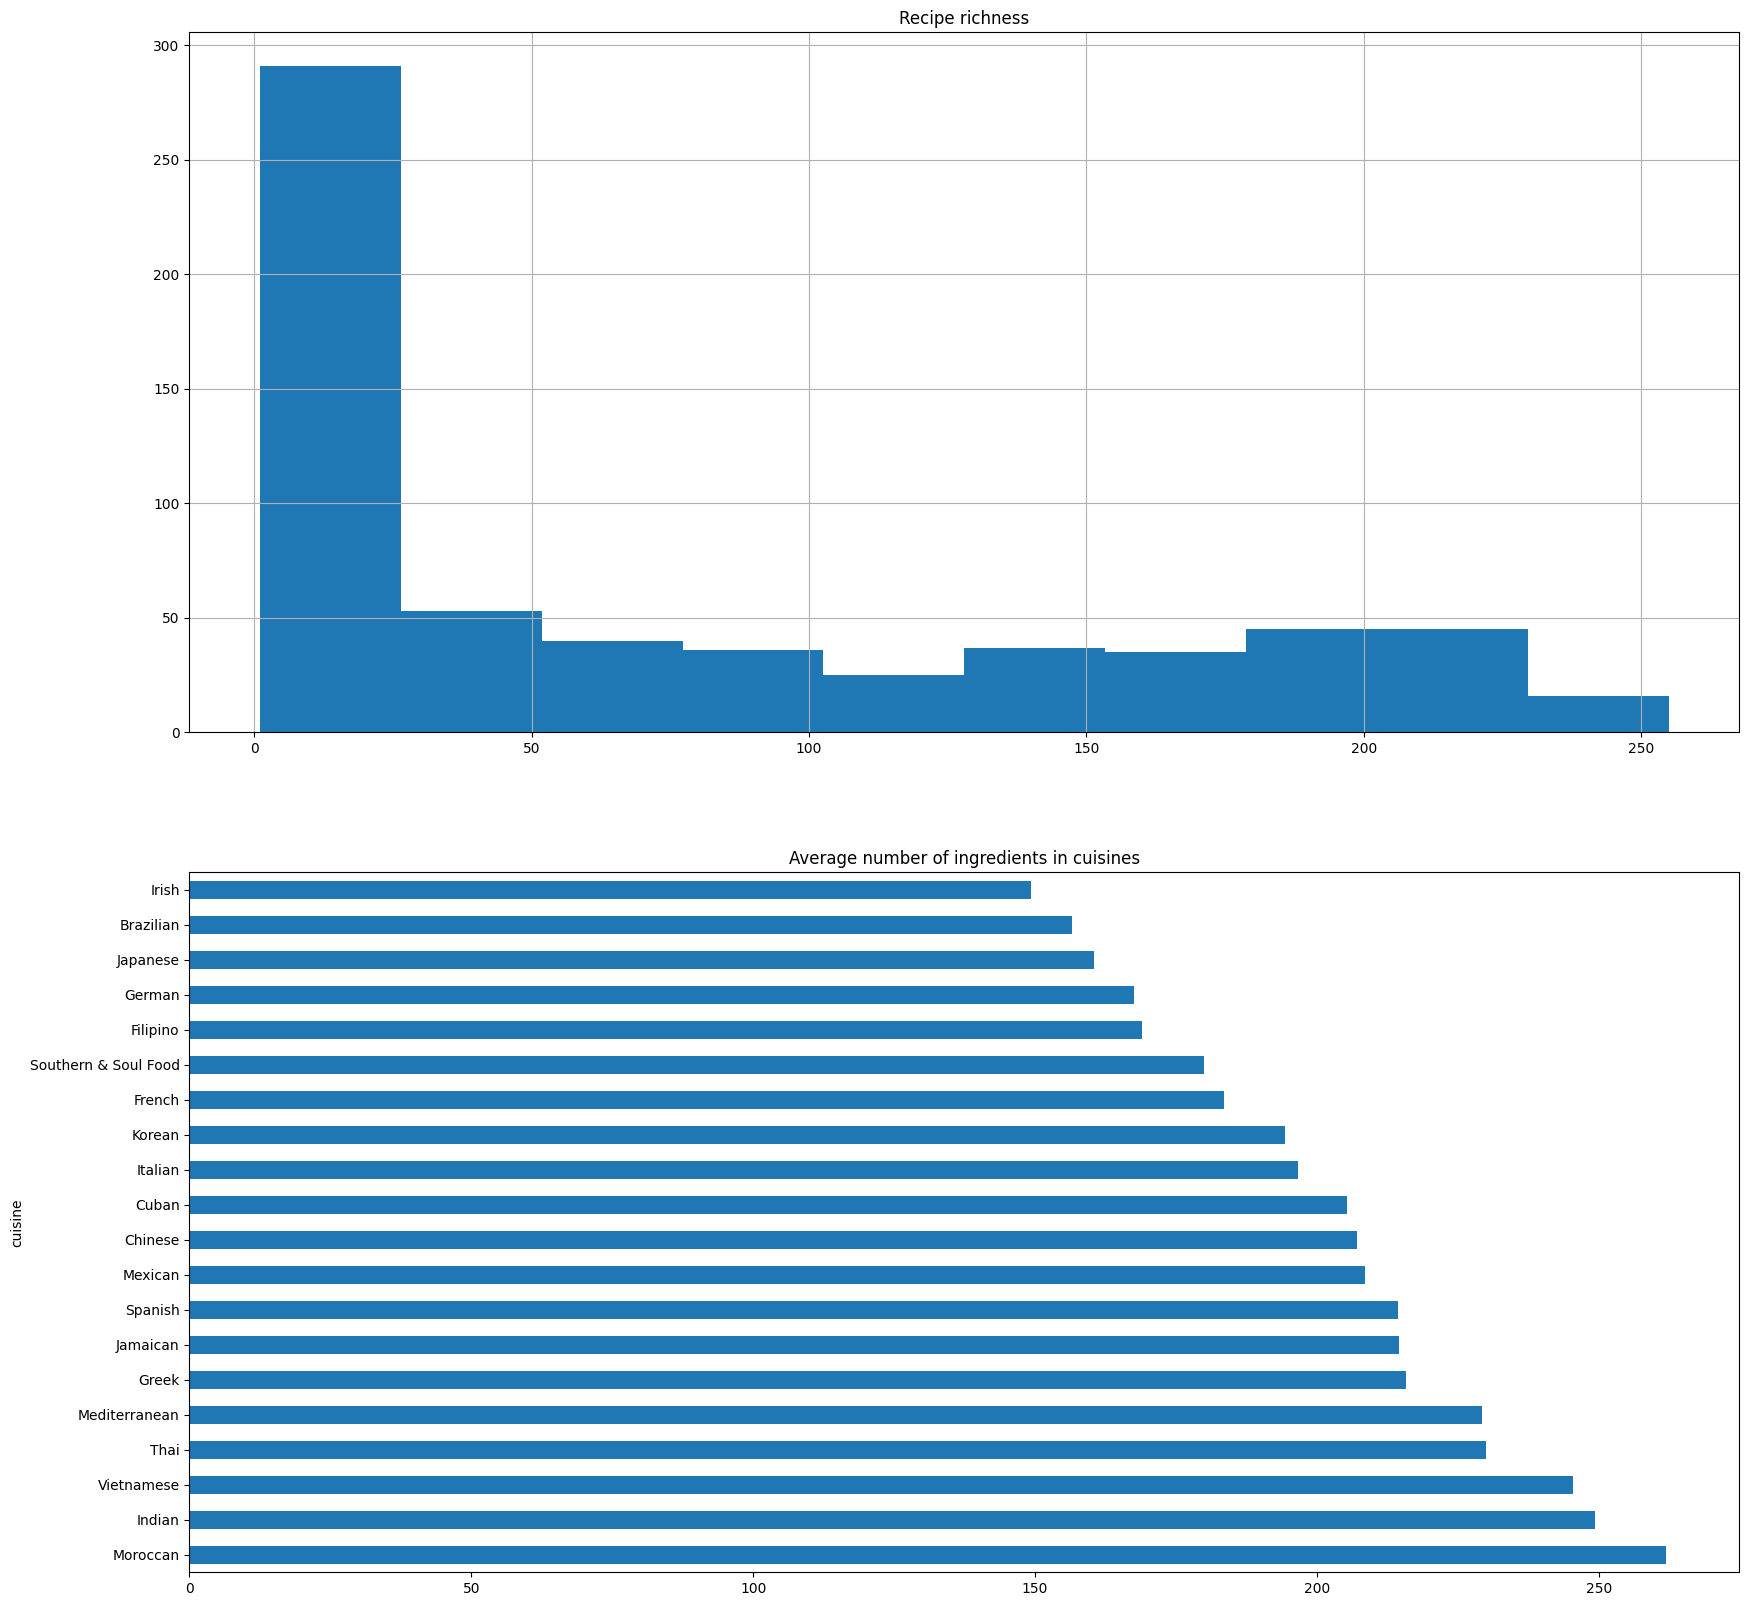

In [11]:
import matplotlib.gridspec as gridspec

df['ingredient_count'] = df.Ingredients.apply(lambda x: len(x))

f = plt.figure(figsize=(20,20))
gs = gridspec.GridSpec(2, 1)

ax1 = plt.subplot(gs[0, :])
df.ingredient_count.value_counts().hist(ax=ax1)
ax1.set_title('Recipe richness', fontsize=12)

ax2 = plt.subplot(gs[1, 0])
df.groupby('cuisine').mean()['ingredient_count'].sort_values(ascending=False).plot(kind='barh', ax=ax2)
ax2.set_title('Average number of ingredients in cuisines', fontsize=12)

plt.show()

In [12]:
from sklearn.model_selection import train_test_split

y = df.cuisine
X = df.Ingredients
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=12345,shuffle=True, test_size=0.2, stratify=y)
X_train

124      ['boneless skinless chicken breasts', 'oil', '...
6770     ['kalamata', 'flat leaf parsley', 'Dijon musta...
19255    ['potatoes', 'large eggplants', 'fresh ground ...
41722    ['collard greens', 'granulated sugar', 'season...
12284    ['butter', 'flour', 'baking powder', 'sugar', ...
                               ...                        
2719     ['onions', 'ginger', 'beef shin', 'beef briske...
35761    ['coconut aminos', 'toasted sesame oil', 'grat...
38266    ['flour', 'sugar', 'salt', 'baking soda', 'but...
8720     ['artichokes', 'seasoned breadcrumbs', 'garlic...
10706    ['onion', 'ground beef', 'garlic', 'Italian se...
Name: Ingredients, Length: 36744, dtype: object

In [13]:
import json
def generate_text(data):
    return [doc.replace('\', \'', ' ').replace('[\'', '').replace('\']', '').lower() for doc in data]
train_text = generate_text(X_train)
test_text = generate_text(X_test)
target = y_train

In [36]:
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(binary=True)
X = tfidf.fit_transform(train_text)
X_test = tfidf.transform(test_text).astype('float16')

lb = LabelEncoder()
y = lb.fit_transform(target)

X.shape

(36744, 3371)

In [33]:
import pickle

with open('../pickles/le_cuisine.pickle', 'wb') as to_write:
    pickle.dump(lb, to_write)
with open('../pickles/tfidf_cuisine.pickle', 'wb') as to_write:
    pickle.dump(tfidf, to_write)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

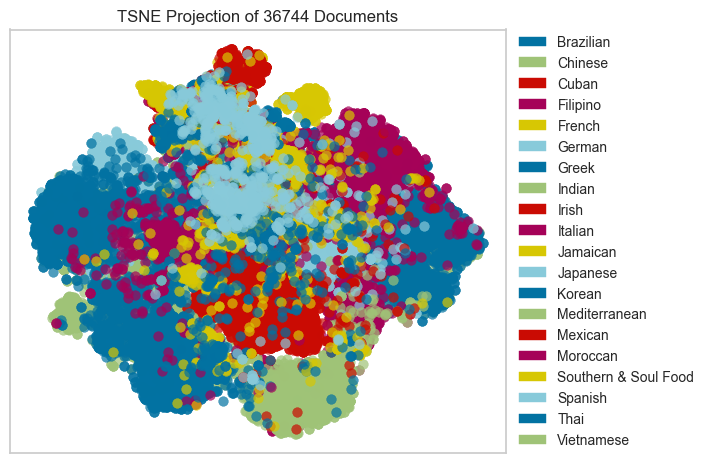

<AxesSubplot: title={'center': 'TSNE Projection of 36744 Documents'}>

In [15]:
from yellowbrick.text import TSNEVisualizer,UMAPVisualizer
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer

def visualize(dim_reduction,encoding,corpus_data,corpus_target,labels = True,alpha=0.7,metric=None):
    if 'tfidf' in encoding.lower():
        encode  = TfidfVectorizer()
    if 'count' in encoding.lower():
        encode = CountVectorizer()
    docs   = encode.fit_transform(corpus_data)
    if labels is True:
        labels = corpus_target
    else:
        labels = None
    if 'umap' in dim_reduction.lower():
        if metric is None:
            viz   = UMAPVisualizer()
        else:
            viz = UMAPVisualizer(metric=metric)
    if 't-sne' in dim_reduction.lower():
        viz = TSNEVisualizer(alpha = alpha)
    viz.fit(docs,labels)
    return viz.show()

visualize('t-sne',"tfidf", train_text, target)

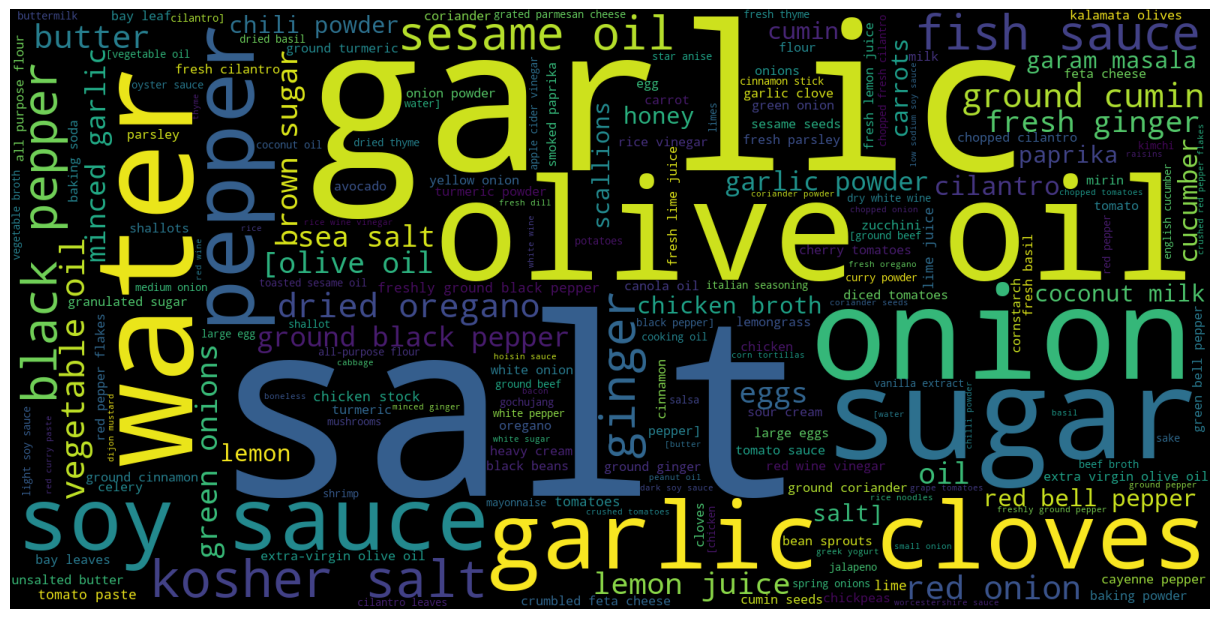

In [16]:
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud

vectorizer = CountVectorizer(tokenizer = lambda x: x.split(', '))
ingredients = vectorizer.fit_transform(df['Ingredients'].replace(to_replace='\'', regex=True, value=''))
unique = vectorizer.get_feature_names_out()
freq = ingredients.sum(axis=0).A1
unique_to_count_map = dict(zip(unique, freq))
tupl = dict(unique_to_count_map.items())
word_cloud = WordCloud(width=1600,height=800,).generate_from_frequencies(tupl)
plt.figure(figsize = (12,8))
plt.imshow(word_cloud)
plt.axis('off')
plt.tight_layout(pad=0)

In [17]:
skfold = StratifiedKFold(n_splits=5, random_state=12345, shuffle=True)

def cross_validation_statistics(classifier, X, y):
    scores = cross_validate(classifier, X , y, cv=skfold, scoring = {'acc': 'accuracy','prec': 'precision_weighted', 'rec': 'recall_macro'})
    print('Cross validation statistics: ')
    print(' Mean Fit Time:', scores['fit_time'].mean())
    print(' Mean Predict Time:', scores['score_time'].mean())
    print(' Mean Accuracy:', scores['test_acc'].mean())
    print(' Mean Weighted Precision:', scores['test_prec'].mean())
    print(' Mean Macro Recall:', scores['test_rec'].mean())

## Decision Tree

In [18]:
from sklearn import tree

dt = tree.DecisionTreeClassifier()
dt.fit(X, y)

y_pred = dt.predict(X_test)
y_pred = lb.inverse_transform(y_pred)

cross_validation_statistics(dt, X, y)

Cross validation statistics: 
 Mean Fit Time: 2.68668475151062
 Mean Predict Time: 0.010602283477783202
 Mean Accuracy: 0.7356575163481965
 Mean Weighted Precision: 0.7351957301969826
 Mean Macro Recall: 0.6871972666347818


## AdaBoost

In [19]:
from sklearn.ensemble import AdaBoostClassifier

adaBoost = AdaBoostClassifier()
adaBoost.fit(X, y)

y_pred = adaBoost.predict(X_test)
y_pred = lb.inverse_transform(y_pred)

cross_validation_statistics(adaBoost, X, y)

Cross validation statistics: 
 Mean Fit Time: 6.153978633880615
 Mean Predict Time: 0.06806817054748535
 Mean Accuracy: 0.5535054780652577
 Mean Weighted Precision: 0.595557129622314
 Mean Macro Recall: 0.47795688710355666


## KNN

In [20]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X, y)

y_pred = knn.predict(X_test)
y_pred = lb.inverse_transform(y_pred)

cross_validation_statistics(knn, X, y)

Cross validation statistics: 
 Mean Fit Time: 0.0048619270324707035
 Mean Predict Time: 9.08145513534546
 Mean Accuracy: 0.8038047088939182
 Mean Weighted Precision: 0.8101577322033728
 Mean Macro Recall: 0.7712601268753978


## Logistic Regression

In [21]:
logisticRegression = LogisticRegression()
logisticRegression.fit(X, y)

y_pred = logisticRegression.predict(X_test)
y_pred = lb.inverse_transform(y_pred)

cross_validation_statistics(logisticRegression, X, y)

Cross validation statistics: 
 Mean Fit Time: 1.9946326732635498
 Mean Predict Time: 0.007331943511962891
 Mean Accuracy: 0.8716524483906172
 Mean Weighted Precision: 0.8690293590114825
 Mean Macro Recall: 0.8343243220351646


## SVC

In [22]:
svc = SVC()
svc.fit(X, y)

y_pred = svc.predict(X_test)
y_pred = lb.inverse_transform(y_pred)

cross_validation_statistics(svc, X, y)

Cross validation statistics: 
 Mean Fit Time: 54.80128021240235
 Mean Predict Time: 19.823123359680174
 Mean Accuracy: 0.8870835784856024
 Mean Weighted Precision: 0.8858214825227547
 Mean Macro Recall: 0.8568501859167343


## Random Forest

In [23]:
rf = RandomForestClassifier()
rf.fit(X, y)

y_pred = rf.predict(X_test)
y_pred = lb.inverse_transform(y_pred)

cross_validation_statistics(rf, X, y)

Cross validation statistics: 
 Mean Fit Time: 14.118256330490112
 Mean Predict Time: 0.1891874313354492
 Mean Accuracy: 0.8495808109161753
 Mean Weighted Precision: 0.8514211829898372
 Mean Macro Recall: 0.7935696392866364


In [ ]:
n_estimators = [50, 100]
max_features = ['auto', 'sqrt']
max_depth = [4, None]
min_samples_split = [2, 4]
min_samples_leaf = [1, 3]
bootstrap = [True, False]

params = {'n_estimators': n_estimators, 'max_features': max_features,
          'max_depth': max_depth, 'min_samples_split': min_samples_split,
          'min_samples_leaf': min_samples_leaf, 'bootstrap': bootstrap}

randomForest = RandomForestClassifier()
rf_cv = GridSearchCV(RandomForestClassifier(), params, cv=skfold)
rf_cv.fit(X, y)

print(f"Best parameters for Random Forest Classifier: {rf_cv.best_params_}\n")

randomForest.set_params(**rf_cv.best_params_)

cross_validation_statistics(randomForest, X, y)

In [ ]:
C = [0.1, 1.0]
solver = ['liblinear', 'newton-cg']
penalty = ['l2', 'elasticnet']
multi_class = ['auto']
max_iter = [100,250]

grid = {
        "C": C, "solver": solver,"penalty": penalty,
        "multi_class": multi_class, "max_iter": max_iter
}

logisticRegression = LogisticRegression()
lr_cv = GridSearchCV(logisticRegression, grid, cv=skfold)
lr_cv.fit(X, y)

print(f"Best parameters: {lr_cv.best_params_}\n")

logisticRegression.set_params(**lr_cv.best_params_)

cross_validation_statistics(logisticRegression, X, y)

Best parameters: {'C': 1.0, 'max_iter': 100, 'multi_class': 'auto', 'penalty': 'l2', 'solver': 'newton-cg'}



LogisticRegression(solver='newton-cg')

In [ ]:
C = [0.1, 1]
gamma = ['scale', 'auto']
kernel = ['linear', 'poly']
degree = [2, 3]
decision_function_shape = ['ovo', 'ovr']

grid = {
    "C": C, "gamma": gamma,"kernel": kernel,
    "decision_function_shape": decision_function_shape,
    "degree": degree
}

svm = SVC()
svm_cv = GridSearchCV(svm, grid, cv=skfold)
svm_cv.fit(X, y)

print(f"Best parameters: {svm_cv.best_params_}\n")

svm.set_params(**svm_cv.best_params_)

cross_validation_statistics(svm, X, y)

In [37]:
import pickle

with open('../pickles/model_cuisine.pickle', 'wb') as to_write:
    pickle.dump(logisticRegression, to_write)